<a href="https://colab.research.google.com/github/greek-nlp/gen-a/blob/main/gr_nlp_gen_a_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import libraries

In [1]:
%%capture
!pip install zenodo-get
!pip install datasets

In [2]:
import os
import json
import shutil
import hashlib
import tarfile
import zipfile
import zenodo_get
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from datasets import load_dataset
import xml.etree.ElementTree as ET

# Load the Greek datasets information

In [3]:
gr_data = pd.read_csv('https://raw.githubusercontent.com/greek-nlp/gen-a/main/data.csv')
aa_gr_data = gr_data[(gr_data.availability=='Yes')&(gr_data.accessibility.isin({'downloadable','online'}))]
aa_gr_data.shape[0]

17

# Source code

In [4]:
# the data for downstream tasks
csv_datasets_folder = "csv_datasets"
os.makedirs(csv_datasets_folder, exist_ok=True)

# the data for pre-training tasks
txt_datasets_folder = "txt_datasets"
os.makedirs(txt_datasets_folder, exist_ok=True)

In [5]:
def wget_download(resource_id, url):
  os.makedirs(str(resource_id), exist_ok=True)
  # Use wget to download the file
  !wget -P {resource_id} {url}


def zenodo_download(resource_id, zenodo_url):
  os.makedirs(str(resource_id), exist_ok=True)
  %cd {resource_id}/
  !zenodo_get {zenodo_url}
  %cd ../


def huggingface_download(resource_id, to_folder, dataset_name, splits, subsets=[None]):
  """
  Download the data from HuggingFace
  """
  # Create the directory if it does not exist
  os.makedirs(str(resource_id), exist_ok=True)
  df_dict = {}
  for subset in subsets:
    # Load the dataset
    dataset = load_dataset(dataset_name, subset)

    for split in splits:
      # Convert the dataset to a Pandas DataFrame
      df_hg = pd.DataFrame(dataset[split])
      if resource_id == '250': #The Papaloukas dataset
        df_hg = df_hg.rename(columns={'label': subset})

      if len(subsets) > 1:
        df_dict[f"{split}_{subset}"] = df_hg
      else:
        df_dict[f"{split}"] = df_hg

      # Save the DataFrame to a CSV file
      if subset is not None:
        df_hg.to_csv(f'{to_folder}/{resource_id}_{subset}_{split}.csv', index=False)
      else:
        df_hg.to_csv(f'{to_folder}/{resource_id}_{split}.csv', index=False)

  return df_dict


def git_sparse_checkout_download(resource_id, repo_url, down_folder, branch):
  """
  Download folder containing the data from github repository
  """
  # Install Git (if not already installed) and configure sparse checkout
  # !sudo apt-get install git -y
  !git init repo_{resource_id}
  %cd repo_{resource_id}
  !git remote add -f origin {repo_url}
  !git config core.sparseCheckout true

  # Define the folder to download
  with open('.git/info/sparse-checkout', 'w') as f:
      f.write(down_folder + '\n')

  # Pull the specific folder from the repository
  !git pull origin {branch}  # Pull from the specified branch

  # Verify if the folder has been downloaded
  if os.path.exists(down_folder):
      print(f"Successfully downloaded {down_folder}")
  else:
      print(f"Failed to download {down_folder}. Please check the folder path and branch name.")

  # Move back to the root directory
  %cd ..

  # Optional: Move the downloaded folder to the root directory and clean up
  !mv repo_{resource_id}/{down_folder} ./{resource_id} || echo "Folder not found: repo_{resource_id}/{down_folder}"
  !rm -rf repo_{resource_id}

In [6]:
#@title Dataset wrappers

class BarzokasDt:

    def __init__(self, datasets, id_=56):
      self.paper_id = id_ # the ID in the shared resource
      self.datasets = datasets
      self.repo_url = self.datasets[self.datasets.paper_id==self.paper_id].URL.iloc[0]
      self.down_folder = 'data/corpora'  # Data folder path within the git repository
      self.branch = "master"
      self.splits = {'train'}
      self.train = self.download()


    def _create_df(self, dataset_folder):
        df_tsv = pd.read_csv(os.path.join(dataset_folder, "metadata.tsv"), sep='\t')
        print(f"tsv records: {df_tsv.shape}")

        data = []
        txt_root_dir = os.path.join(dataset_folder, "text")
        for txt_folder in os.listdir(txt_root_dir):
          for txt_file in os.listdir(os.path.join(txt_root_dir, txt_folder)):
              if txt_file.endswith('.txt'):
                  # Extract the ID from each TXT filename
                  txt_id = os.path.splitext(txt_file)[0]

                  # Read the content of each TXT file
                  with open(os.path.join(txt_root_dir, txt_folder, txt_file), 'r', encoding='utf-8') as f:
                      txt_content = f.read()

                  # Merge the ID, title, and text content into a new DataFrame
                  row = df_tsv[df_tsv['id'] == txt_id]
                  if not row.empty:
                      row_data = row.iloc[0].to_dict()
                      row_data['text'] = txt_content
                      row_data['status'] = txt_folder
                      data.append(row_data)

        # Create the final DataFrame
        df_final = pd.DataFrame(data)
        return df_final

    def download(self):
      git_sparse_checkout_download(self.paper_id, self.repo_url, self.down_folder, self.branch)
      barzokas_df_list = []
      for data_fname in os.listdir(f"{self.paper_id}"):
        dataset_folder = f"{self.paper_id}/{data_fname}"
        df_56 = self._create_df(dataset_folder)
        df_56["publisher"] = data_fname
        barzokas_df_list.append(df_56)

      df = pd.concat(barzokas_df_list)
      return df

    def get(self, split='train'):
      assert split in {'train'}
      return self.train

    def save_to_csv(self, path = csv_datasets_folder):
      self.train.to_csv(os.path.join(path, f'barzokas.csv'), index=False)


class KorreDt:
  def __init__(self, datasets, id_=244):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      # Download data
      self.repo_url = self.resource.iloc[0].URL
      self.down_folder = 'GNC'  # Data folder path within the git repository
      self.branch = "main"
      self.splits = {'train'}
      self.dataset = None
      self.train = self.download()

  def download(self):
      git_sparse_checkout_download(self.resource_id, self.repo_url, self.down_folder, self.branch)

      # Merge the two annotators dataframes
      df_annA = pd.read_excel(f'{self.resource_id}/GNC_annotator_A.xlsx')
      df_annA.columns = ["label_annA", "original_text_annA", "corrected_text_annA", "error_description_annA", "error_type_annA", "fluency_annA"]
      df_annB = pd.read_excel(f'{self.resource_id}/GNC_annotator_B.xlsx')
      df_annB.columns = ["label_annB", "original_text_annB", "corrected_text_annB", "error_description_annB", "error_type_annB", "fluency_annB"]
      df_ann = pd.merge(df_annA, df_annB, left_index=True, right_index=True, how='inner')

      # Corrected text
      with open(f"{self.resource_id}/orig.txt", 'r', encoding='utf-8') as file:
          lines = file.readlines()
      df_orig = pd.DataFrame(lines, columns=['original_text'])
      df_orig['original_text'] = df_orig['original_text'].str.strip()
      df_orig.replace('', np.nan, inplace=True)

      # Corrected text
      with open(f"{self.resource_id}/corr.txt", 'r', encoding='utf-8') as file:
          lines = file.readlines()
      df_corr = pd.DataFrame(lines, columns=['corrected_text'])
      df_corr['corrected_text'] = df_corr['corrected_text'].str.strip()
      df_corr.replace('', np.nan, inplace=True)
      # merge txts
      df_txt = pd.merge(df_orig, df_corr, left_index=True, right_index=True, how='inner')

      # merge the annotations and the txt
      df_gnc = pd.merge(df_txt, df_ann, left_index=True, right_index=True, how='inner')
      df_gnc.drop(columns=['original_text_annA', 'original_text_annB', 'corrected_text_annA', 'corrected_text_annB'], inplace=True)
      df_gnc.dropna(how='all', inplace=True)
      df_gnc.original_text = df_gnc.original_text.astype(str)
      df_gnc.corrected_text = df_gnc.corrected_text.astype(str)

      return df_gnc


  def get(self, split='train'):
    assert split in {'train'}
    return self.train


class ZampieriDt:
    def __init__(self, datasets, id_=341):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      # Download data
      self.repo_url = self.resource.iloc[0].URL
      self.splits = ["train", "test"]
      self.dataset = self.download()
      self.train = self.dataset['train']
      self.test = self.dataset['test']

    def download(self, split='train'):
      dataset_name = 'strombergnlp/offenseval_2020'
      subsets = ["gr"]
      df_dict = huggingface_download(self.resource_id, csv_datasets_folder, dataset_name, self.splits, subsets=subsets)
      return df_dict

    def get(self, split='train'):
      assert split in {'train', 'test'}
      return self.dataset[split]


class AntonakakiDt:
    def __init__(self, datasets, id_=428):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.train = self.download()
      self.splits = {'train'}
      self.dataset = None

    def download(self):
      data_types = {'tweet_id': str, 'text': str}
      ref_df = pd.read_csv('428_referendum_sentiment.csv', dtype=data_types)
      ref_df.drop(columns=["positive", "negative", "sentiment"], inplace=True)
      ref_df.drop_duplicates(subset=['text'], inplace=True)

      elect_df = pd.read_csv('428_elections_sentiment.csv', dtype=data_types)
      elect_df.drop(columns=["positive", "negative", "sentiment"], inplace=True)
      elect_df.drop_duplicates(subset=['text'], inplace=True)

      df_428 = pd.concat([elect_df, ref_df], axis=0)
      df_428.dropna(inplace=True)
      return df_428

    def get(self, split='train'):
      assert split in {'train'}
      return self.train


class ProkopidisDt:
    def __init__(self, datasets, id_=486):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.splits = {'train'}
      self.train = self.download()
      self.train['text'] = self.train.Greek

    def _generate_checksum(self, text):
      return hashlib.sha256(text.encode()).hexdigest()

    def get(self, split='train'):
      assert split in {'train'}
      return self.train

    def download(self):
      langs_dict = {
          "eng": "English",
          "epo": "Esperanto",
          "fas": "Farsi",
          "fil": "Filipino",
          "fra": "French",
          "heb": "Hebrew",
          "hin": "Hindi",
          "hun": "Hungarian",
          "ind": "Indonesian",
          "ita": "Italian",
          "jpn": "Japanese",
          "khm": "Khmer",
          "kor": "Korean",
          "mkd": "Macedonian",
          "mlg": "Malagasy",
          "mya": "Burmese",
          "nld": "Dutch",
          "ori": "Odia",
          "pol": "Polish",
          "por": "Portuguese",
          "rum": "Romanian",
          "rus": "Russian",
          "spa": "Spanish",
          "sqi": "Albanian",
          "srp": "Serbian",
          "swa": "Swahili",
          "swe": "Swedish",
          "tur": "Turkish",
          "urd": "Urdu",
          "zhs": "Chinese-simplified",
          "zht": "Chinese-traditional"
      }

      for other_lang in langs_dict:
        data_url = f"{self.repo_url}archives/ell-{other_lang}.zip"
        wget_download(self.resource_id, data_url)
        # Unzip
        with zipfile.ZipFile(f"{self.resource_id}/ell-{other_lang}.zip", 'r') as zip_ref:
          zip_ref.extractall(f"{self.resource_id}/ell-{other_lang}")

      pgv_df_list = []

      namespace = {'xml': 'http://www.w3.org/XML/1998/namespace'}

      # Iterate through TMX files in the directory
      for other_lang, other_lang_name in langs_dict.items():
        print(other_lang)
        file_path = f"{self.resource_id}/ell-{other_lang}/pgv/ell-{other_lang}.tmx"
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Initialize lists to store data
        score = []
        source_lang = []
        target_lang = []

        # Iterate through tu elements
        for tu in root.findall('.//tu'):
            score.append(tu.find('.//prop[@type="score"]').text)

            source = tu.find('.//tuv[@xml:lang="ell"]/seg', namespaces=namespace).text
            target = tu.find(f'.//tuv[@xml:lang="{other_lang}"]/seg', namespaces=namespace).text
            source_lang.append(source)
            target_lang.append(target)

        # Create DataFrame
        df_pair = pd.DataFrame({'Greek': source_lang, other_lang_name: target_lang, f"Greek_{other_lang_name}_score": score})
        df_pair['Checksum'] = df_pair[f'Greek'].apply(self._generate_checksum)
        df_pair.drop_duplicates(subset='Checksum', inplace=True)
        pgv_df_list.append(df_pair)

      # Initialize merged DataFrame with the first DataFrame
      df_pgv = pgv_df_list[0]

      # Merge all DataFrames in the list
      for df_pgv_pair in pgv_df_list[1:]:
          df_pgv = pd.merge(df_pgv, df_pgv_pair, on=['Checksum', 'Greek'], how='outer')

      df_pgv.drop(columns=['Checksum'], inplace=True)
      return df_pgv


class FitsilisDt:
    def __init__(self, datasets, id_=722):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.splits = {'train'}
      self.train = self.download()


    def get(self, split='train'):
      assert split in {'train'}
      return self.train

    def _read_file_content(self, filename):
        try:
            with open(os.path.join(str(self.resource_id), "Parliamentary Questions Corpus", f"{filename}.txt"), 'r', encoding='utf-16') as file:
                content = file.read()
                content_utf8 = content.encode('utf-8')
                return content_utf8
        except FileNotFoundError:
            return None

    def download(self):
      zenodo_download(self.resource_id, self.repo_url)
      with zipfile.ZipFile(f"{self.resource_id}/Parliamentary Questions Corpus.zip", 'r') as zip_ref:
        zip_ref.extractall(str(self.resource_id))

      df_parl_quest = pd.read_csv(f"{self.resource_id}/Parliamentary Questions Corpus Metadata.csv", delimiter=";")
      # Apply the function to replace the 'link serialNr' column with the file contents
      df_parl_quest['text'] = df_parl_quest['link serialNr'].apply(self._read_file_content)
      df_parl_quest['text'] = df_parl_quest['text'].str.decode('utf-8')
      return df_parl_quest

class BarziokasDt:
    def __init__(self, datasets, id_=285):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.down_folder = 'dataset'  # Data folder path within the git repository
      self.branch = "master"
      self.splits = {'train'}
      self.word_based_data = self.download()
      self.train = self.reduce()

    def get(self, split='train'):
      assert split in {'train'}
      return self.train

    def reduce(self):
      sentences,gt4,gt18 = {},{},{}
      counter = 0
      for index, row in self.word_based_data.iterrows():
        if len(str(row['Sentence#'])) > 5:
          counter += 1
          sentences[counter] = [row['Word']]
          gt4[counter] = [row['NE_4Tagset']]
          gt18[counter] = [row['NE_18Tagset']]
        else:
          sentences[counter].append(row['Word'])
          gt4[counter].append(row['NE_4Tagset'])
          gt18[counter].append(row['NE_18Tagset'])
      return pd.DataFrame({'sentence':sentences, 'tags4': gt4, 'tags18':gt18})


    def download(self):
      git_sparse_checkout_download(self.resource_id, self.repo_url, self.down_folder, self.branch)
      barziokas_4_df = pd.read_csv(f"{self.resource_id}/elNER4/elNER4_iobes.csv")
      barziokas_4_df = barziokas_4_df.rename(columns={'Tag': 'NE_4Tagset'})
      barziokas_18_df = pd.read_csv(f"{self.resource_id}/elNER18/elNER18_iobes.csv")
      barziokas_18_df = barziokas_18_df.rename(columns={'Tag': 'NE_18Tagset'})

      barziokas_df = pd.merge(barziokas_4_df, barziokas_18_df, left_index=True, right_index=True, how='inner')
      barziokas_df = barziokas_df.drop(['Sentence #_y', 'Word_y', 'POS_y'], axis=1)
      barziokas_df.columns = ['Sentence#', 'Word', 'POS', 'NE_4Tagset', 'NE_18Tagset']
      return barziokas_df


class PapaloukasDt:
    def __init__(self, datasets, id_=250):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.dataset_name = 'AI-team-UoA/greek_legal_code'
      self.subsets = ["volume", "chapter", "subject"]
      self.splits = {"train", "validation", "test"}
      self.dataset = self.download()

    def download(self):
      df_dict = huggingface_download(self.resource_id, csv_datasets_folder, self.dataset_name, self.splits, subsets=self.subsets)

      df_splits = {}
      for split in self.splits:
        df_split_list = [df_ for name, df_ in df_dict.items() if split in name]
        df_split = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True, how='inner'), df_split_list)
        df_split = df_split.drop(['text_x', 'text_y'], axis=1)
        df_splits[split] = df_split

      return df_splits

    def get(self, split = 'train'):
      assert split in self.splits
      return self.dataset[split]


class ProkopidisCrawledDt:
    def __init__(self, datasets, id_=284):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.splits = {'train'}
      self.train = self.download()

    def get(self, split='train'):
      assert split in self.splits
      return self.train


    def download(self):
      wget_download(self.resource_id, f"{self.repo_url}/resources/greek_corpus.tar.gz")
      tar_file_path = f"{self.resource_id}/greek_corpus.tar.gz"

      with tarfile.open(tar_file_path, "r:gz") as tar:
        # Extract all files to the current directory
        tar.extractall()

      data_folder = 'data-20130219-20191231'
      data = []
      for filename in os.listdir(data_folder):
        with open(os.path.join(data_folder, filename), 'r') as f:
          file_content = f.read()
          data.append({"text": file_content, "filename": filename.split(".txt")[0]})

      df = pd.DataFrame(data)
      return df


class DritsaDt:
    def __init__(self, datasets, id_=728):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL.split(",")[0]
      self.splits = {'train'}
      self.train = self.download()
      self.train['text'] = self.train['speech']

    def get(self, split='train'):
      assert split in self.splits
      return self.train

    def download(self):
      zenodo_download(self.resource_id, self.repo_url)
      target_file = 'dataset_versions/tell_all.csv'
      with zipfile.ZipFile(f"{self.resource_id}/Greek Parliament Proceedings Dataset_Support Files_Word Usage Change Computations.zip", 'r') as zip_ref:
          for member in zip_ref.namelist():
            if member == target_file:
              csv_path = zip_ref.extract(member)
              df_728 = pd.read_csv(csv_path)
              return df_728


class AntonakakiDt:
    def __init__(self, datasets, id_=428):
      self.resource_id = id_
      self.resource = datasets.loc[datasets.paper_id==self.resource_id]
      self.repo_url = self.resource.iloc[0].URL
      self.splits = {'train'}
      self.train = self.download()

    def get(self, split='train'):
      assert split in self.splits
      return self.train

    def download(self):
      print('WARNING: Need to update to use the FigShare API')
      !gdown 11gbKJd29sM4ZuqyTmPnLBMPfOGof_U8t
      !gdown 11orLo9LPRuvxoRpCfQsDVfJKKCELA7-f
      data_types = {'tweet_id': str, 'text': str}
      ref_df = pd.read_csv('428_referendum_sentiment.csv', dtype=data_types)
      ref_df.drop(columns=["positive", "negative", "sentiment"], inplace=True)
      ref_df.drop_duplicates(subset=['text'], inplace=True)

      elect_df = pd.read_csv('428_elections_sentiment.csv', dtype=data_types)
      elect_df.drop(columns=["positive", "negative", "sentiment"], inplace=True)
      elect_df.drop_duplicates(subset=['text'], inplace=True)

      df_428 = pd.concat([elect_df, ref_df], axis=0)
      df_428.dropna(inplace=True)
      return df_428


# Accessing the datasets

In [115]:
barzokas = BarzokasDt( datasets=aa_gr_data )
barzokas.get('train').sample()

,id,title,author,type,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,authorYearOfDeath,publishedYear,tokensCount,text,status,publisher
206,openBook540,Λέσχες Ανάγνωσης – Μιλάμε για βιβλία…,NaN,Εγχειρίδιο,NaN,Λέσχες Ανάγνωσης – Μιλάμε για βιβλία….pdf,https://www.openbook.gr/lesxes-anagnwsis/,http://bit.ly/2CI3bGb,NaN,NaN,2006,6159.0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,malformed,openbook


In [39]:
korre = KorreDt( datasets = aa_gr_data )
korre.get('train').sample()

,original_text,corrected_text,label_annA,error_description_annA,error_type_annA,fluency_annA,label_annB,error_description_annB,error_type_annB,fluency_annB
43,Με βάση αυτό τα κράτη κατηγοριοποιούνται σε ισ...,Με βάση αυτό τα κράτη κατηγοριοποιούνται σε ισ...,c,NaN,NaN,4.0,c,NaN,NaN,5.0


In [57]:
zampieri = ZampieriDt(datasets = aa_gr_data)
zampieri.get('train').sample()

,id,original_id,text,subtask_a
6755,6755,8163,Η Αννα Μαρία το είπε απλά η Ελευθερία το συνέχ...,0


In [125]:
prokopidis = ProkopidisDt(aa_gr_data)
prokopidis.get('train').sample()

,Greek,English,Greek_English_score,Esperanto,Greek_Esperanto_score,Farsi,Greek_Farsi_score,Filipino,Greek_Filipino_score,French,...,Greek_Swedish_score,Turkish,Greek_Turkish_score,Urdu,Greek_Urdu_score,Chinese-simplified,Greek_Chinese-simplified_score,Chinese-traditional,Greek_Chinese-traditional_score,text
14882,Πηγή φωτογραφίας: σελίδα στο Facebook Nahum Pe...,Photo source: Nahum Pembu Muwowo Facebook page.,4.6157417,NaN,NaN,NaN,NaN,NaN,NaN,Imade de: Nahum Pembu Muwowo (Sur Facebook),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Πηγή φωτογραφίας: σελίδα στο Facebook Nahum Pe...


In [74]:
fitsilis = FitsilisDt(aa_gr_data)
fitsilis.get().sample()

,Protocol Number,Date,Type,Subject,Link,Session/Period,Party,Date Last Modified,Submitter,Ministries,Ministers,Question File,Answer Files,link serialNr,text
1852,5658,4/5/2018,Ερωτήσεις,Ανάγκη άμεσης ανανέωσης του ατομικού εξοπλισμο...,https://www.hellenicparliament.gr/Koinovouleft...,Γ΄ Σύνοδος ΙΖ΄ ΠΕΡΙΟΔΟΣ (ΠΡΟΕΔΡΕΥΟΜΕΝΗΣ ΚΟΙΝΟΒ...,- ΝΕΑ ΔΗΜΟΚΡΑΤΙΑ-,30/5/2018,- Ανδριανός Σωτηρίου Ιωάννης-,Εσωτερικών-,Σκουρλέτης Παναγιώτης (Πάνος) (Υπουργός Εσωτερ...,https://www.hellenicparliament.gr/UserFiles/c0...,https://www.hellenicparliament.gr/UserFiles/67...,10702813,Κατά την πρόσφατη επίσκεψή μου στις Πυροσβεστι...


In [79]:
barziokas = BarziokasDt(aa_gr_data)
barziokas.get().sample()

,sentence,tags4,tags18
2963,"[Τότε, η, ΔΙΟΔΟΣ, υποβάλλει, εκ, νέου, την, ασ...","[O, O, S-ORG, O, O, O, O, O, O, O, O]","[O, O, S-ORG, O, O, O, O, O, O, O, O]"


In [85]:
papaloukas = PapaloukasDt(aa_gr_data)
papaloukas.get('train').sample()

,label_x,label_y,text,label
17235,38,67,61. ΑΠΟΦΑΣΙΣ ΥΠΟΥΡΓΟΥ ΕΜΠΟΡΙΟΥ της 4/11 Νοεμ. ...,692


In [95]:
prokopidis_crawled = ProkopidisCrawledDt(aa_gr_data)
prokopidis_crawled.get().sample()

,text,filename
235,"""Αγώνας δρόμου"" για την ανακεφαλαιοποίηση\nΡΕΠ...",201509221800-avgi-10809_10949-5872296


In [94]:
dritsa = DritsaDt(aa_gr_data)
dritsa.get().sample()

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,government,member_region,roles,member_gender,speaker_info,speech,text
1172524,μαυρωτας παρασκευα γεωργιος,29/11/2017,period 17,session 3,sitting 36,το ποταμι,['τσιπρα π. αλεξιου(21/09/2015-08/07/2019)'],αττικης,['βουλευτης'],male,NaN,Όχι.,Όχι.


In [105]:
antonakaki = AntonakakiDt(aa_gr_data)
antonakaki.get().sample()

,tweet_id,text
55946,636216184619335680,θεοδωράκης #alphatv η ανασφάλεια που ποτίζει ο...


In [116]:
raw = [dritsa, prokopidis_crawled, fitsilis, barzokas, antonakaki]
labelled = [prokopidis, zampieri, korre, papaloukas, barziokas]

# Exploration with language modeling

In [118]:
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM
raw_datasets = {'dritsa21':dritsa.get('train'),
                'barzokas20':barzokas.get('train'),
                'prokopidis20':prokopidis.get('train'),
                'antonakaki17':antonakaki.get('train'),
                'fitsilis21':fitsilis.get('train')}

In [127]:
train_sets = {}
test_sets = {}
for dataset_name in raw_datasets:
  print(dataset_name)
  dataset = raw_datasets[dataset_name]
  dataset = dataset[dataset.text.notna()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  train_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[:1000] # lower lim
  test_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[1000:1500]

dritsa21
barzokas20
prokopidis20
antonakaki17
fitsilis21


In [ ]:
ppls = {}
for dname in raw_datasets:
  train = train_sets[dname]
  test = test_sets[dname]
  lm = LM(gram="CHAR")
  lm.train(' '.join(train.values)[:65000]) # length of min dataset
  ppls[dname] = {}
  for dname2 in raw_datasets:
    scores = test_sets[dname2].apply(lm.cross_entropy)
    ppls[dname][dname2] = scores.mean()
    #ppls_std[dname][dname2] = scores.std()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


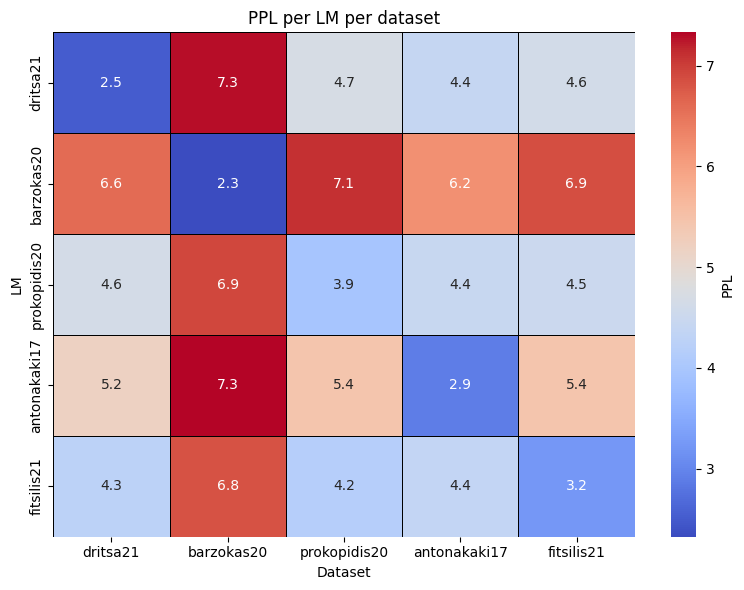

In [129]:
ppls_pd = pd.DataFrame(ppls)
plt.figure(figsize=(8, 6))
sns.heatmap(ppls_pd, annot=True, cmap='coolwarm', linewidths=0.5,
            linecolor='black', cbar_kws={'label': 'PPL'});

# Add labels and a title
plt.title('PPL per LM per dataset'); plt.xlabel('Dataset'); plt.ylabel('LM');
plt.tight_layout();
plt.savefig('ppl_heatmap.pdf', dpi=300, format='PDF')

# The Text Clustering Benchmark

In [8]:
papaloukas = PapaloukasDt(aa_gr_data)
papaloukas.get('test').sample()

,label_x,label_y,text,label
480,1,148,35. ΑΠΟΦΑΣΙΣ ΥΠΟΥΡΓΟΥ ΕΘΝΙΚΗΣ ΟΙΚΟΝΟΜΙΑΣ Αριθ....,1643


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Convert the text documents to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(papaloukas.dataset['test'].text.values)
tfidf_matrix_dense = tfidf_matrix.toarray()

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (9516, 136515)


In [10]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

test = papaloukas.dataset['test']
# kmeans
for num_clusters in (47, 389, 2285):
  print(f"K={num_clusters}")
  km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  km.fit(tfidf_matrix)
  test[f'kmeans{num_clusters}'] = km.labels_
  print(f"NMI: {nmi(test.label_x.values, km.labels_):.4f}")
  print(f"AMI: {ami(test.label_x.values, km.labels_):.4f}")
  print(f"ARI: {ari(test.label_x.values, km.labels_):.4f}")
  print(f"Sil: {sil(tfidf_matrix_dense, km.labels_, sample_size=1000):.4f}")
  print()

K=47
NMI: 0.1488
AMI: 0.1187
ARI: 0.0174
Sil: 0.0001

K=389
NMI: 0.3223
AMI: 0.1923
ARI: 0.0216
Sil: -0.0184

K=2285
NMI: 0.4878
AMI: 0.2071
ARI: 0.0150
Sil: -0.0037



In [ ]:
# Use the following to include st. significance
#out = [] # to report on test samples
#for i in range(100):
#  sample = papaloukas.sample(200)
#  out.append(nmi(sample.volume.values, sample.kmeans))
# Print the evaluation scores
#pd.Series(out).agg(['mean', 'sem'])

In [11]:
ground_truth = {47: 'label_x', 389:'label_y', 2285:'label'}
for num_clusters in ground_truth:
  print(f"K={num_clusters}")
  print(f"NMI: {nmi(test[ground_truth[num_clusters]].values, test[f'kmeans{num_clusters}']):.4f}")
  print(f"AMI: {ami(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print(f"ARI: {ari(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print()

K=47
NMI: 0.1488
AMI: 0.1187
ARI: 0.0174

K=389
NMI: 0.4713
AMI: 0.1866
ARI: 0.0314

K=2285
NMI: 0.7569
AMI: 0.2176
ARI: 0.0489

